In [232]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy.interpolate import griddata
from sklearn.model_selection import StratifiedKFold


In [233]:
#Load the data
SensorData = pd.read_csv('data/raw/BCIsensor_xy.csv',header=None)
Img_data_1 = pd.read_csv('data/raw/feaSubEImg_1.csv',header=None)
Img_data_2 = pd.read_csv('data/raw/feaSubEImg_2.csv',header=None)
Overt_data_1 = pd.read_csv('data/raw/feaSubEOvert_1.csv',header=None)
Overt_data_2 = pd.read_csv('data/raw/feaSubEOvert_2.csv',header=None)

In [234]:
#number of rows and columns in each dataset
print(SensorData.shape)
print(Img_data_1.shape)
print(Img_data_2.shape)
print(Overt_data_1.shape)
print(Overt_data_2.shape)


(102, 2)
(204, 120)
(204, 120)
(204, 120)
(204, 120)


In [235]:
def plot_electrode_positions(data):
    x_coords = data[0]
    y_coords = data[1]
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
    plt.scatter(x_coords, y_coords, color='blue')  # Plots the electrode positions as blue dots
    for i in range(data.shape[1] - 1):
        plt.plot([x_coords[i], x_coords[i+1]], [y_coords[i], y_coords[i+1]], color='purple')  # Connects with lines

    # Annotating specific electrodes
    annotations = [0, 53, 54, 101]  # Example based on your previous image
    for annotation in annotations:
        plt.text(x_coords[annotation], y_coords[annotation], str(annotation+1), color='black')

    # Additional plot settings
    plt.title('Electrode Positions')
    plt.axis('off')  # Hide axis
    plt.show()


In [236]:
def svm_classifier(X_train, y_train, X_test, y_test, lambda_val=1):
    C = 1 / lambda_val
    clf = SVC(kernel='linear', C=C,max_iter= 500000)
    clf.fit(X_train, y_train)
    try:
        channel_weights = clf.coef_[0]
    except:
        channel_weights = np.arange(204)

    y_hat = clf.predict(X_test)
    #accuracy = (y_hat == y_test).sum() / len(y_test)
    accuracy = accuracy_score(y_test, y_hat)
    decision_statistics = clf.decision_function(X_test)

    return accuracy, channel_weights, decision_statistics, len(clf.support_vectors_)

In [237]:
kf_outer = StratifiedKFold(n_splits=6)
lambdas = [0.01, 1, 100, 10000]
def cross_validation(X,y):
    outer_results = []
    # First-level cross-validation
    for train_index, test_index in kf_outer.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Inner (second-level) cross-validation for regularization parameter tuning
        kf_inner = StratifiedKFold(n_splits=5)
        inner_results = []
        
        for lambda_val in lambdas:
            lambda_scores = []
            
            for inner_train_index, inner_test_index in kf_inner.split(X_train, y_train):
                X_inner_train, X_inner_test = X_train[inner_train_index], X_train[inner_test_index]
                y_inner_train, y_inner_test = y_train[inner_train_index], y_train[inner_test_index]
                
                # Train and evaluate the model on the inner fold
                accuracy, _, _, _ = svm_classifier(X_inner_train, y_inner_train, X_inner_test, y_inner_test, lambda_val)
                lambda_scores.append(accuracy)
            
            # Store the average accuracy for this lambda value
            inner_results.append(np.mean(lambda_scores))
        
        # Select the best lambda value for this outer fold
        best_lambda = lambdas[np.argmax(inner_results)]
        
        # Evaluate the model on the outer fold using the selected lambda value
        accuracy, channel_weights, decision_statistics, num_sv = svm_classifier(X_train, y_train, X_test, y_test, best_lambda)
        outer_results.append(accuracy)

    # Compute the average accuracy across all outer folds
    average_accuracy = np.mean(outer_results)
    print(f"Average accuracy from two-level cross-validation: {average_accuracy}")
    #print best lambda value
    print(f"Best lambda value: {best_lambda}")

In [238]:
def plot_roc_curve(y_test, decision_statistics):
    fpr, tpr, thresholds = roc_curve(y_test, decision_statistics)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [239]:
def show_channel_weights(channel_weights_x, channel_weights_y, plot_title='Channel Weights Plotted on Brain Surface'):
    # Combine x and y weights to get the magnitude for each electrode
    channel_weights_magnitude = np.sqrt(channel_weights_x**2 + channel_weights_y**2)
    
    # Assuming SensorData is loaded and contains the x, y coordinates of the electrodes
    # And that it has been sorted in the same order as the weights
    x = SensorData.iloc[:, 0].values
    y = SensorData.iloc[:, 1].values
    
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate the weights onto the grid using cubic interpolation
    zi = griddata((x, y), channel_weights_magnitude, (xi, yi), method='cubic')

    # Visualize using pcolor
    plt.figure()
    plt.pcolor(xi, yi, zi, cmap='jet', shading='auto')
    plt.colorbar(label='Weight Magnitude')
    plt.scatter(x, y, c='k', s=5)  # Optionally, plot the original electrode positions
    plt.axis('equal')
    plt.axis('off')
    plt.title('SVM Weights on Brain Surface')
    plt.show()

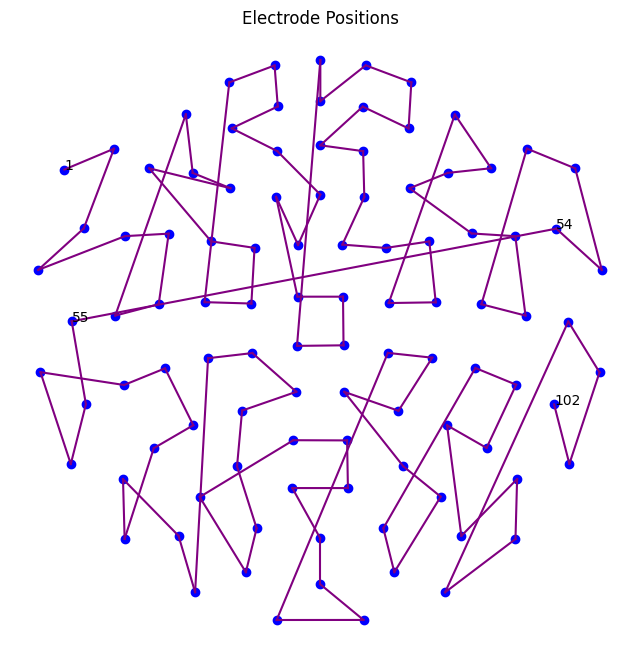

In [240]:
plot_electrode_positions(SensorData.values.T)

In [241]:
def run_svm(data1, data2):
    X = np.concatenate((data1.T, data2.T))
    y = np.array([0]*len(data1.T) + [1]*len(data2.T))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y)

    # Standardizing the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    accuracy, channel_weights, decision_statistics, num_support_vectors = svm_classifier(X_train, y_train, X_test, y_test)
    # Display the results
    print("Accuracy:", accuracy)
    print("Number of Support Vectors:", num_support_vectors)
    print("Decision Statistics for all test samples:", decision_statistics)
    return y_test, decision_statistics,channel_weights

Accuracy: 0.8958333333333334
Number of Support Vectors: 41
Decision Statistics for all test samples: [ 4.52111997  0.54502238 -3.26661827 -0.61720099 -0.32347605 -0.98255563
 -1.07183936  2.75042606 -8.51384924  1.84803066  4.21125372  2.68720285
  3.31474718  1.02505184  6.36557666 -3.67011527  2.26214498  1.58987787
  3.03972742 -2.76561345  2.81929377  3.19969712 -3.42668801 -0.09593444
  3.54656697  0.14866589 -4.74436866  4.15769065 -0.56719947  5.09935971
 -3.51206825  2.92715758  1.94777004 -2.81759322 -3.14686797 -3.3548504
  2.1240384  -0.75958085 -0.39648281 -2.83729392  0.81149926  0.93947485
 -3.08631578 -3.03168729  2.64913238  1.93252213 -2.14020729 -2.31709758]


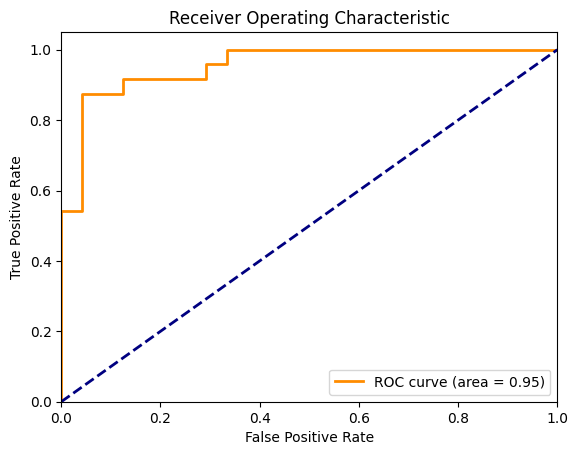

/var/folders/rt/wydyk1yn1096_jp1cjy1506m0000gn/T/ipykernel_61128/2658383343.py:19: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='Weight Magnitude')


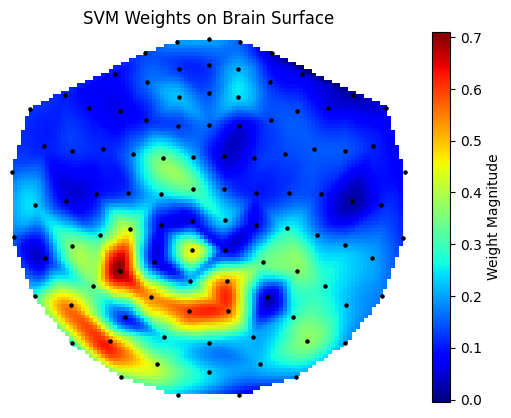

In [242]:
y_test, decision_statistics,channel_weights = run_svm(Img_data_1, Img_data_2)
plot_roc_curve(y_test, decision_statistics)
channel_weights_x = channel_weights[::2] 
channel_weights_y = channel_weights[1::2] 
show_channel_weights(channel_weights_x, channel_weights_y)


In [243]:
X = np.concatenate((Img_data_1.T, Img_data_2.T))
y = np.array([0]*len(Img_data_1.T) + [1]*len(Img_data_2.T))
cross_validation(X,y)

Average accuracy from two-level cross-validation: 0.8791666666666665
Best lambda value: 0.01


Accuracy: 0.9583333333333334
Number of Support Vectors: 34
Decision Statistics for all test samples: [ 2.69507595 -2.70339792 -0.06030041  3.64744034 -3.55630106  2.65884759
 -0.67173027  1.06654488  0.49861024 -0.31978662  0.86546749  1.26081152
  2.34719823  1.36463642  2.65587506 -0.03854756  4.86429222  3.98837358
  3.22521266 -1.78699045  1.35765115  2.02161873 -2.54224336 -1.36021586
  1.40759657  1.13082308 -2.27441138  2.47393909 -2.92415822  0.2398189
 -2.24522314  2.04428566  0.89405334 -0.93191219 -5.07745306 -0.85206897
  0.04319383 -1.46453605 -1.20763156 -3.10407443 -1.71589584  4.08700947
 -3.34953122 -2.09218542 -2.14191116  2.89134784 -2.76513051 -2.02072526]


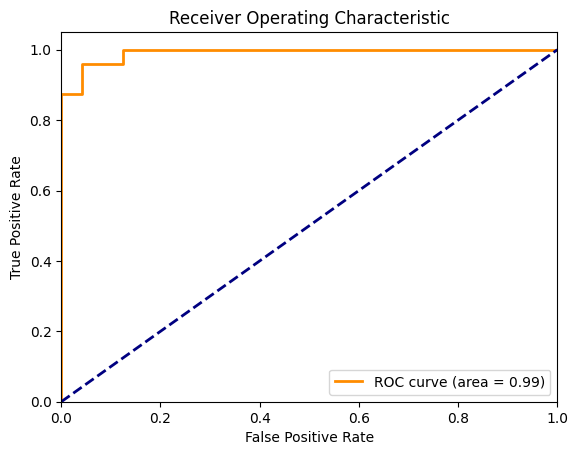

/var/folders/rt/wydyk1yn1096_jp1cjy1506m0000gn/T/ipykernel_61128/2658383343.py:19: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='Weight Magnitude')


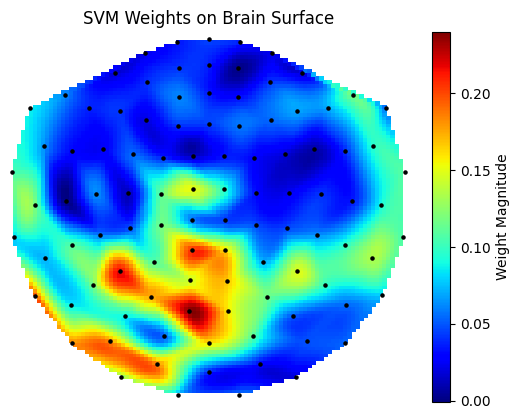

In [244]:
y_test, decision_statistics, channel_weights= run_svm(Overt_data_1, Overt_data_2)
plot_roc_curve(y_test, decision_statistics)
channel_weights_x = channel_weights[::2] 
channel_weights_y = channel_weights[1::2] 
show_channel_weights(channel_weights_x, channel_weights_y)

In [245]:
X = np.concatenate((Overt_data_1.T, Overt_data_2.T))
y = np.array([0]*len(Overt_data_1.T) + [1]*len(Overt_data_2.T))
cross_validation(X,y)

Average accuracy from two-level cross-validation: 0.9541666666666667
Best lambda value: 0.01


Accuracy: 0.9125
Number of Support Vectors: 50
Decision Statistics for all test samples: [  3.34987294  -2.99172558  -3.92486887  -5.62574422  -0.37496772
  -1.87602219  -7.65658393  -4.02706918  -2.62831174  -9.24801289
  -3.08182003  -4.38944562   2.63976799  -1.18874185  -4.47444257
   3.35949133  -0.9001864   -2.67629754  -2.12002411  -0.02464285
  -3.40536759   0.67566766  -8.39833233  -6.71961352  -1.80741223
  -2.64515296 -13.26813538  -8.80732142  -4.70273004  -5.48000457
  -1.92554576  -3.76865074  -6.63326615   1.33476454  -7.34190063
  -0.24908226  -0.25751603  -2.83897446  -3.33472837  -2.5281688
  -2.66555144  -2.42604208  -4.19737602  -3.54854562   0.7468717
  -4.65184082   0.1916232   -1.85345663  -7.69421828  -2.3942392
  -4.31197643  -1.4808309   -3.33993678  -0.91479235   0.62489681
  -1.21518662   0.5443202    0.90374668  -2.89091233  -1.00783865
   0.31207677   0.20684714   1.09128995  -2.89155452  -5.86589145
  -7.65953334  -0.93958663  -3.28657987  -4.54219805  -7

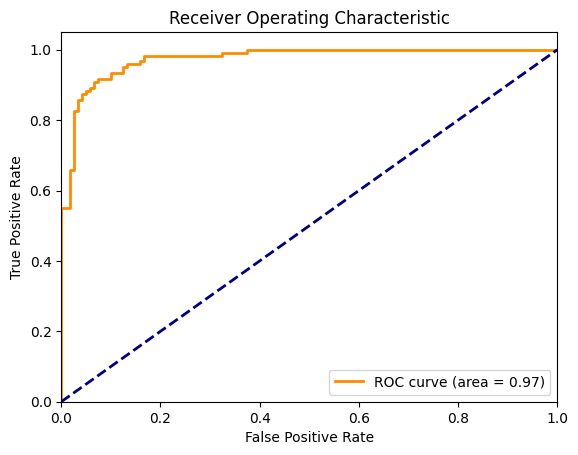

/var/folders/rt/wydyk1yn1096_jp1cjy1506m0000gn/T/ipykernel_61128/2658383343.py:19: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='Weight Magnitude')


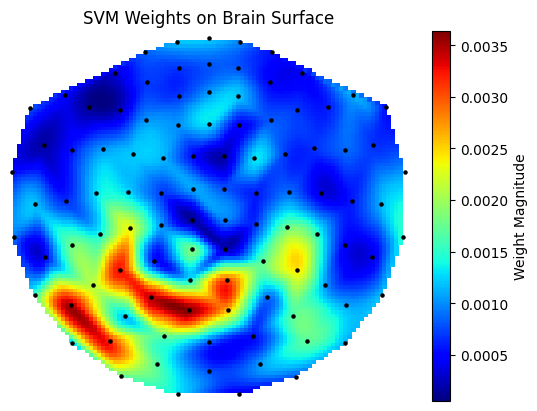

In [247]:
#train on Imagined data and test on Overt data
X_train = np.concatenate((Img_data_1.T, Img_data_2.T))
y_train = np.array([0]*len(Img_data_1.T) + [1]*len(Img_data_2.T))
X_test = np.concatenate((Overt_data_1.T, Overt_data_2.T))
y_test = np.array([0]*len(Overt_data_1.T) + [1]*len(Overt_data_2.T))    
accuracy, channel_weights, decision_statistics, num_support_vectors = svm_classifier(X_train, y_train, X_test, y_test)
print("Accuracy:", accuracy)
print("Number of Support Vectors:", num_support_vectors)
print("Decision Statistics for all test samples:", decision_statistics)
plot_roc_curve(y_test, decision_statistics)
channel_weights_x = channel_weights[::2]
channel_weights_y = channel_weights[1::2]
show_channel_weights(channel_weights_x, channel_weights_y)

Accuracy: 0.8833333333333333
Number of Support Vectors: 39
Decision Statistics for all test samples: [ -3.13662306  -2.81756199  -2.21916974  -4.30447883  -4.27346777
  -2.92681956  -0.64821038   0.13020546  -3.57409497  -2.25614598
  -4.24100117  -3.17627943  -4.46140512  -2.51122036  -4.54730703
  -0.55111752  -4.18311008  -0.3421617   -5.05991947  -3.03702444
  -8.22728374  -4.11074848  -4.60728347  -2.5325093   -4.36803915
  -3.52912751   0.2575143   -0.98658596  -1.5528741   -0.20167793
  -1.23662958  -3.03426522   0.02809953  -0.46378002  -1.54836507
  -4.633421    -0.06076929  -1.34780607  -2.71009252  -0.83974116
  -0.15934959  -2.75153183  -2.48189431  -3.62530449  -2.20723501
  -3.0042362   -0.37488426  -2.0510604   -2.34418596   0.49404374
   0.61605885  -0.95914376  -0.71693983  -0.60068337  -6.30402523
  -0.95896114  -1.0368363   -3.10351067  -1.11072994  -2.90652344
  -2.81557796  -1.93325018  -2.4296299   -1.23190515  -2.04760857
  -1.38755517  -2.74836231  -1.00578785  

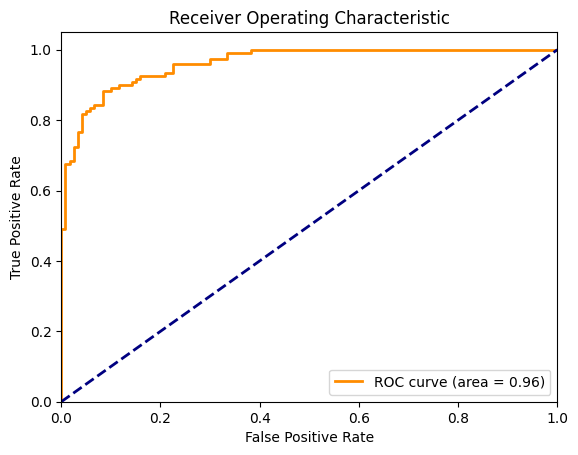

/var/folders/rt/wydyk1yn1096_jp1cjy1506m0000gn/T/ipykernel_61128/2658383343.py:19: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='Weight Magnitude')


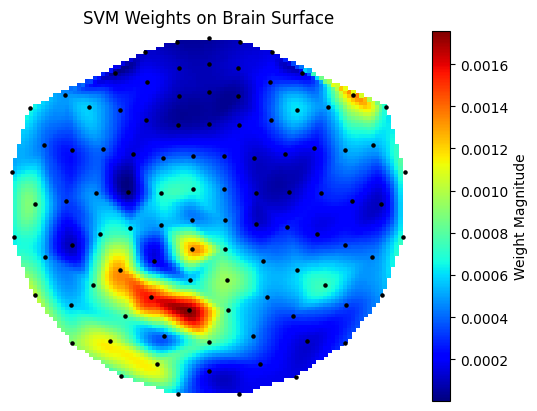

In [248]:
#train on Imagined data and test on Overt data
X_test = np.concatenate((Img_data_1.T, Img_data_2.T))
y_test = np.array([0]*len(Img_data_1.T) + [1]*len(Img_data_2.T))
X_train = np.concatenate((Overt_data_1.T, Overt_data_2.T))
y_train = np.array([0]*len(Overt_data_1.T) + [1]*len(Overt_data_2.T))    
accuracy, channel_weights, decision_statistics, num_support_vectors = svm_classifier(X_train, y_train, X_test, y_test)
print("Accuracy:", accuracy)
print("Number of Support Vectors:", num_support_vectors)
print("Decision Statistics for all test samples:", decision_statistics)
plot_roc_curve(y_test, decision_statistics)
channel_weights_x = channel_weights[::2]
channel_weights_y = channel_weights[1::2]
show_channel_weights(channel_weights_x, channel_weights_y)